In [2]:
from nilearn import image

# Load power template coords

powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)

print(powerimg.shape)

(91, 109, 91)


In [3]:
import numpy as np

# Load ROI coordinates

import re

# Radius 5
pat = re.compile('.*Power(\d+)([^#]+)#(-?\d+,-?\d+,-?\d+).*')

def parseLine(pat, line):
    res = pat.search(line)
    if res:
        idx, bfn, mni = res.groups()
        mni = np.array([int(coord) for coord in mni.split(',')]+[1])
        return (idx,bfn,mni)
    return None

roifile = '/home/anton/Documents/Tulane/Hackathon/power264/power264CoorMNI.sclib'
rois = []

with open(roifile, 'r') as f:
    for line in f.readlines():
        p = parseLine(pat, line)
        rois.append(p)

rois = [p for p in rois if p is not None]
print(len(rois))

264


In [4]:
# Create input and output filenames

import re
from pathlib import Path

tasks = ['rest', 'nback', 'emoid']
bids_in_dir = '/run/media/anton/Samsung_T5/PNC_Test_Out'
out_dir = '/run/media/anton/Samsung_T5/data'
in_file_map = {}
out_file_map = {}

for file in Path(bids_in_dir).iterdir():
    if file.is_dir() and re.match('sub-.*', file.name):
        subj = file.name[4:]
        in_file_map[subj] = {}
        out_file_map[subj] = {}
        for task in tasks:
            taskfiles = list(Path(f'{bids_in_dir}/{file.name}/func/')
                             .glob(f'{file.name}_task-{task}*bold.nii.gz'))
            if len(taskfiles) > 1:
                print(f'More than one {task} file for {file.name}!')
                continue
            if len(taskfiles) == 0:
                print(f'No {task} file for {file.name}')
                continue
            in_file_map[subj][task] = f'{bids_in_dir}/{file.name}/func/{taskfiles[0].name}'
            out_file_map[subj][task] = f'{out_dir}/{file.name}-{task}.pkl'
            
print(in_file_map)
print(out_file_map)

{'600009963128': {'rest': '/run/media/anton/Samsung_T5/PNC_Test_Out/sub-600009963128/func/sub-600009963128_task-rest_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'nback': '/run/media/anton/Samsung_T5/PNC_Test_Out/sub-600009963128/func/sub-600009963128_task-nback_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'emoid': '/run/media/anton/Samsung_T5/PNC_Test_Out/sub-600009963128/func/sub-600009963128_task-emoid_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'}, '600018902293': {'rest': '/run/media/anton/Samsung_T5/PNC_Test_Out/sub-600018902293/func/sub-600018902293_task-rest_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'nback': '/run/media/anton/Samsung_T5/PNC_Test_Out/sub-600018902293/func/sub-600018902293_task-nback_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'emoid': '/run/media/anton/Samsung_T5/PNC_Test_Out/sub-600018902293/func/sub-60001890229

In [11]:
# Load files
# Extract and save timeseries

import pickle
import warnings

def getRoiImage(img, powerimg, tp):
    vol = image.index_img(img, tp)
    vol_resamp = None
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        vol_resamp = image.resample_to_img(vol, powerimg)
    vol_rois = image.math_img('(img1 > 0)*img2', img1=powerimg, img2=vol_resamp)
    return vol_rois
    
def extractSignal(volRoiImg, rois, invxform):
    signal = np.zeros(len(rois))

    for i,roi in enumerate(rois):
        x,y,z,_ = np.floor(invxform@roi[-1]).astype('int')
        signal[i] = np.sum(volRoiImg.get_fdata()[x-2:x+2,y-2:y+2,z-2:z+2])
        
    return signal

for subj,tasks in in_file_map.items():
    for task,fname in tasks.items():
        try:
            img = image.load_img(fname)
            
            signal = np.zeros((264,img.shape[-1]))
            invaff = np.linalg.inv(powerimg.affine)

            for tp in range(img.shape[-1]):
                volImg = getRoiImage(img, powerimg, tp)
                signal[:,tp] = extractSignal(volImg, rois, invaff)
                if tp%100 == 0:
                    print(f'Completed tp {tp}')
            with open(out_file_map[subj][task], 'wb') as f:
                pickle.dump(signal, f)
        except Exception as e:
            print(f'Problem with {subj} {task}')
            print(e)
            continue
    print(f'Completed {subj}')

Completed tp 0
Completed tp 100
Completed tp 0
Completed tp 100
Completed tp 200
Completed tp 0
Completed tp 100
Completed tp 200
Completed 600009963128
Completed tp 0
Completed tp 100
Completed tp 0
Completed tp 100
Completed tp 200
Completed tp 0
Completed tp 100
Completed tp 200
Completed 600018902293
Completed tp 0
Completed tp 100
Completed tp 0
Completed tp 100
Completed tp 200
Completed tp 0
Completed tp 100
Completed tp 200
Completed 600020927179
Completed tp 0
Completed tp 100
Completed tp 0
Completed tp 100
Completed tp 200
Completed tp 0
Completed tp 100
Completed tp 200
Completed 600031697545
Completed tp 0
Completed tp 100
Completed tp 0
Completed tp 100
Completed tp 200
Completed tp 0
Completed tp 100
Completed tp 200
Completed 600038720566
Completed tp 0
Completed tp 100
Completed tp 0
Completed tp 100
Completed tp 200
Completed tp 0
Completed tp 100
Completed tp 200
Completed 600039015048
Completed tp 0
Completed tp 100
Completed tp 0
Completed tp 100
Completed tp 200
C

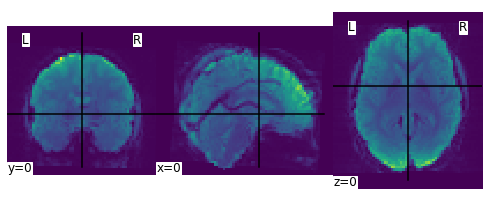

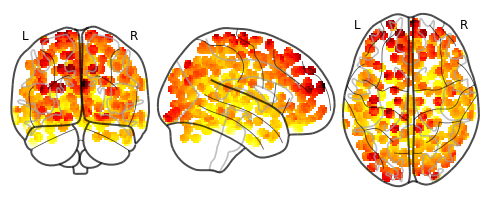

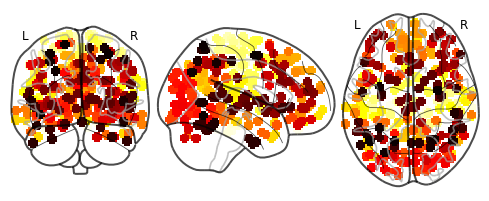

In [12]:
from nilearn import plotting

vol0 = image.index_img(img, 0)
plotting.plot_img(vol0, cut_coords=(0,0,0))

plotting.plot_glass_brain(volImg, cut_coords=(0,0,0))

plotting.plot_glass_brain(powerimg, cut_coords=(0,0,0))

In [47]:
import pickle

rest0_new = None

subjs = list(out_file_map.keys())
with open(out_file_map[subjs[1]]['rest'], 'rb') as f:
    rest0_new = pickle.load(f)

print(rest0_new.shape)

(264, 124)


In [48]:
import numpy as np

np.sum(rest0_new, axis=1) > 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

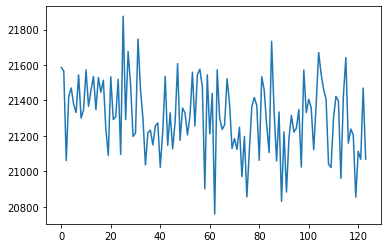

In [49]:
import matplotlib.pyplot as plt

plt.plot(rest0_new[6])
plt.show()

In [86]:
from scipy import signal

tr = 1.83
N = rest0_new.shape[-1]

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y - np.mean(y, axis=-1, keepdims=True)

# filtSignal = butter_bandpass_filter(rest0_new, np.array([1.83/50*N,1.83/2*N]), 2*N)
filtSignal = butter_lowpass_filter(rest0_new, 1.83/20*N, 2*N)
print(filtSignal.shape)

(264, 124)


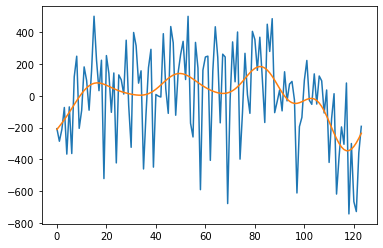

In [87]:
roi = 5

plt.plot(rest0_new[roi]-np.mean(rest0_new[roi]))
plt.plot(filtSignal[roi])
plt.show()

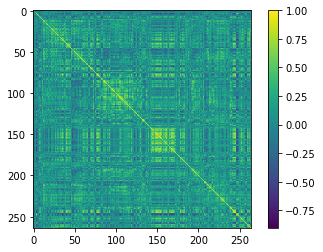

In [88]:
prest0n = np.corrcoef(rest0_new)
prest0nf = np.corrcoef(filtSignal)

plt.imshow(prest0n)
plt.colorbar()
plt.show()

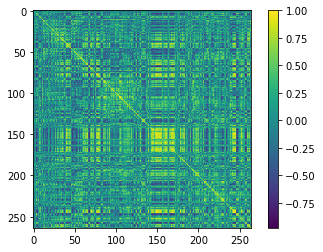

In [89]:
plt.imshow(prest0nf)
plt.colorbar()
plt.show()

In [54]:
# import pickle

# mega = None

# with open('/home/anton/Documents/Tulane/Research/PNC_Good/MegaMeta3.pkl', 'rb') as f:
#     mega = pickle.load(f)
    
# print(list(mega.keys()))

In [55]:
prest0o = np.corrcoef(mega[600018902293]['rest'])
print(prest0o.shape)

(264, 264)


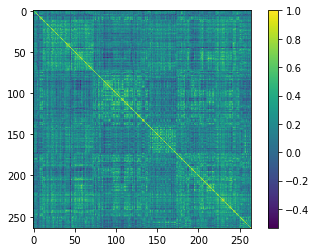

In [56]:
plt.imshow(prest0o)
plt.colorbar()
plt.show()